# Assignment 3
Name: Max Yuhas <br>
Professor: Smita Kirshnaswamy <br>
TA: Matthew Amodio <br>

## Problem 1
Understanding TensorFlow!

### Part 1
In tflecture1_2.py, make sure you understand what tf.Variable, tf.Session() do. Explain what
init = tf.global_variables_initializer() and init.run() do, and how this code differs from
tflecture1_1.py.

In [3]:
#tflecture_1.py
# from '09_up_and_running_with_tensorflow.jpynb'

import tensorflow as tf

x = tf.Variable(3, name='X')   # create a variable, set its value to 3
y = tf.Variable(4, name='Y')

f = x*x*y + y + 2              # f is also a TF variable (overloaded operators)

# variables are not initialized yet

# a better way (which makes sure session is closed when done)

with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

print(result)       # Python v. 3.x print statement

42


In [4]:
#tflecture_2.py
# from '09_up_and_running_with_tensorflow.jpynb'
# Demonstrate global_variables_initalizer

import tensorflow as tf

tf.reset_default_graph()       # always a good idea

x = tf.Variable(3, name='X')   # create a variable, set its value to 3
y = tf.Variable(4, name='Y')

f = x*x*y + y + 2              # f is also a TF variable (overloaded operators)

init = tf.global_variables_initializer()  # this creates a special node to initiliaze stuff

with tf.Session() as sess:
    init.run()        # initially all the variables in the node
    result = f.eval()

print(result)       # Python v. 3.x print statement

42


**Comments:** <br>
In the second chunk above - tflecture_2.py - tf.Variable() constructs a variable, with a given value and name. Here `x` is defined as a variable Tensor with value 3 and name "X". Tensors can also be functions or operations, such as the function defined above, `f = x*x*y + y + 2`. tf.Session() runs all of the computation for the defined tensors and operations, then automatically closes it once the computation has been completed.
<br>
tf.global_variables_initializer() and init.run() define and then run the initilaizer for the global variables (as it essentially says in the name). Here, we are initializing the variables that have already been defined to make sure they have the values we have given them. Putting the `init = tf.global_variables_initializer()` last makes sure that all variables before this line are being initialized. In the tflecture_1.py, we initialzie each x and y variable separate, but in tflecture_2.py they are all initialized in the when we run init.run() inside our tf.Sessio(). It is important to note that we are only initialzing variables, we do not need to initialize all tensors (like the f operation).

### Part 2
Compare tflecture1 3.py with tflecture1 4.py. What do line 32, line 78-87, line 94-102 in
tflecture1 3.py do? What does line 57 in tflecture1 4.py do? Briefly Explain. Make sure you
have installed sklearn before testing with the code. <br>
-Line 32 in tflecture1 3.py <br>
`theta = tf.matmul(tf.matmul(tf.matrix inverse(tf.matmul(XT, X)),XT),y)` <br>
-Line 57 in tflecture1 4.py. <br>
`gradients = tf.gradients(mse,[theta])[0]` <br>

In [12]:
#tflecture_3.py
# Linear regression with TF
# from '09_up_and_running_with_tensorflow.jpynb'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.datasets import fetch_california_housing

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


reset_graph()
housing = fetch_california_housing()
m,n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

#%%

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

# Solve X theta = y
XT = tf.transpose(X)
#Line 32 below:
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

# to print the estimated value:
print('thetavalue\n',theta_value)

#%%

# Compare with pure NumPy:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print('theta_numpy\n',theta_numpy)

#%%

# Compare with scikit-learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1, 1))

print('theta scikit\n',np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

#%%
# Use batch gradient descent --------------------------------------------

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale the data
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

reset_graph()

n_epochs = 1000             # number of iterations of gradient descent algorithm
learning_rate = 0.01        # gradient descent step size

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y

#Line 78-87 start -----------
# Computes the mean (reduces to a scalar value)
mse = tf.reduce_mean(tf.square(error), name="mse")

# Compute the gradient (2/M)*X'X
gradients = 2/m * tf.matmul(tf.transpose(X), error)

# create a node that assigns a new value to a variable
# (This implements the gradient descent algorithm
training_op = tf.assign(theta, theta - learning_rate * gradients)
#----------- line 87 end
#  This is equivalent to writing
#  theta <-- theta - learning_rate * gradients

#Line 94-102 start -----------
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)             # Do this once at the beginning of all the iterations, same as init.run()

    for epoch in range(n_epochs):    # iterate over the training epochs
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print('theta_graddesc\n',best_theta)
#----------- line 102 end

thetavalue
 [[-3.7171074e+01]
 [ 4.3633682e-01]
 [ 9.3871783e-03]
 [-1.0717344e-01]
 [ 6.4540231e-01]
 [-4.1238391e-06]
 [-3.7809242e-03]
 [-4.2373490e-01]
 [-4.3720812e-01]]
theta_numpy
 [[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]
theta scikit
 [[-3.69419202e+01]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]
Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.71450055
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
theta_graddesc
 [[ 2.0685523 ]
 [ 0.8874027 ]
 [ 0.14401656]
 [-0.34770885]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145283]
 [-0.6375278 ]]


In [13]:
#tflecture_4.py
# Linear regression with TF
# from '09_up_and_running_with_tensorflow.jpynb'
# 

# This is the same as the last (gradient descent), except
# that it uses TF's ability to compute gradients

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.datasets import fetch_california_housing

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


reset_graph()
housing = fetch_california_housing()
m,n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

#%%

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

#%%
# Use batch gradient descent --------------------------------------------

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale the data
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

reset_graph()

n_epochs = 1000             # number of iterations of gradient descent algorithm
learning_rate = 0.01        # gradient descent step size

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y

# Computes the mean (reduces to a scalar value)
mse = tf.reduce_mean(tf.square(error), name="mse")

#Line 57 below:
gradients = tf.gradients(mse, [theta])[0]
#  compute the gradient of the mse with respect to theta
#  The tf.gradients() function actually returns a list, so the [0] "unbrackets"
#      the list to just return the element of the list

# create a node that assigns a new value to a variable
# (This implements the gradient descent algorithm
training_op = tf.assign(theta, theta - learning_rate * gradients)
#  This is equivalent to writing
#  theta <-- theta - learning_rate * gradients


init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)             # Do this once at the beginning of all the iterations

    for epoch in range(n_epochs):    # iterate over the training epochs
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print('theta_graddesc\n',best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.7145004
Epoch 200 MSE = 0.56670487
Epoch 300 MSE = 0.55557173
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436363
Epoch 600 MSE = 0.53962904
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.53406775
Epoch 900 MSE = 0.5321473
theta_graddesc
 [[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


**Comments:** <br>
In tflecture_3.py, line 32 defines the matrix form solution to the least squares linear regression: $$\Theta = (X^{T}X)^{-1}X^{T}Y $$
tf.matmul and tf.matrix_inverse are operations that perform matrix multiplication and create the inverse of a matrix respectively. Then, lines 78-87 define the gradient descent algorithm and the mean squared error to train, evaluate, and update the theta estimate as the session runs. In line 82, tf.assign() allows us to update the value of theta (first input) using the gradient descent equation given (second input).
Finally, lines 94-102 initialize our variables as usual, then we perform training over the given number of epochs. At each 100 epochs, it prints the current mean squared error. Finally, it prints the current theta values once the number of epochs of training has been reached.
<br> <br>
In tflecture_4.py, line 57 uses the built in tf.gradients() operation to calculate the gradient with respect to the mean squared error so we do not have to manually perform the gradient descent algorithm as we did with `gradients = 2/m * tf.matmul(tf.transpose(X), error)` in tflecture_3.py. As the comments in tflecture_4.py say, tf.gradients() returns a list, so we take the zero element to return the gradient value.

### Part 3
Based on what tflecture1 4.py does, implement the prob1.py TO DO part using the TensorFlow
optimizer. Is the output different from tflecture1 4.py? Save your code as prob1.py. Hint: You
might only need two lines to set up the optimizer and use the optimizer to minimize the MSE.

In [41]:
# Linear regression with TF
# from '09_up_and_running_with_tensorflow.jpynb'
# 

# Use TF optimizer
# 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.datasets import fetch_california_housing

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


reset_graph()
housing = fetch_california_housing()
m,n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

#%%

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

#%%
# Use batch gradient descent --------------------------------------------

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale the data
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

reset_graph()

n_epochs = 1000             # number of iterations of gradient descent algorithm
learning_rate = 0.01        # gradient descent step size

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y

# Computes the mean (reduces to a scalar value)
mse = tf.reduce_mean(tf.square(error), name="mse")

### TO DO ###
# Using TF's optimizer (here a gradient descent optimizer)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(mse)
###End TO DO

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)             # Do this once at the beginning of all the iterations

    for epoch in range(n_epochs):    # iterate over the training epochs
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(train_op)
    
    best_theta = theta.eval()
    print('theta_graddescoptimizer\n',best_theta)

Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.5305594
Epoch 200 MSE = 0.52515537
Epoch 300 MSE = 0.5244485
Epoch 400 MSE = 0.5243412
Epoch 500 MSE = 0.52432424
Epoch 600 MSE = 0.5243215
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
theta_graddescoptimizer
 [[ 2.0685577 ]
 [ 0.8296404 ]
 [ 0.11875559]
 [-0.26556668]
 [ 0.30572915]
 [-0.00450187]
 [-0.03932704]
 [-0.8998372 ]
 [-0.87049496]]


**Comments:** <br>
If we use a correctly sized learning rate (here I chose 0.1), then, after 1000 epochs, we get a very similar mean squared error and theta values. They are actually almost identical values. The added code defines the optimizer as the `optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)`, but other optimizers can be used here such as an Adagrad or Adam optimizers. Then we need to train by minimizing the mean squared error using this gradient descent optimizer (`train_op = optimizer.minimize(mse)`). Then when we run the session, `sess.run(train_op)` continuously trains our model using this optimizer as it runs through the number of epochs.

## Problem 2

### Part 1
It’s tempting to use gradient descent to try to learn good values for hyper-parameters such as λ and η.
Can you think of an obstacle to using gradient descent to determine λ? Can you think of an obstacle
to using gradient descent to determine η?
<br> <br>
**Comments:** <br>
In general, it is not reasonable to use gradient descent to determine hyper-parameters, because there is often not a smooth surface for the model's loss function with respect to the hyper-parameters. Additionally, it would be extremely computationally expensive to get a more detailed surface here as we would need to get exact values for the parameters within the model. When performind gradient descent to determine the step-size $\eta$, one obstacle could be that, often times, an adaptive step-size based on number of iterations is more useful when performing gradient descent. This allows the algorithm to agressively pursue a minimum at first, then move more conservatively towards a minimum. One obstacle to using gradient descent to determine the parameter weight $\lambda$ is that an intialy large $\lambda$ would mean that the first iterations would have loss functions dominated by this weight penalty, so the parameters within the model would learn very slowly. This relates to the general issue of massive computation.

### Part 2

Modify your code for problem 1.3 to use an adaptive learning rate using AdagradOptimizer in TensorFlow. Record your output and save your code as prob2.py. Comment on how you chose any of the
parameters.

In [3]:
# Linear regression with TF
# from '09_up_and_running_with_tensorflow.jpynb'
# 

# Use TF optimizer
# 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.datasets import fetch_california_housing

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


reset_graph()
housing = fetch_california_housing()
m,n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m,1)), housing.data]

#%%

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

#%%
# Use batch gradient descent --------------------------------------------

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scale the data
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

reset_graph()

n_epochs = 1000             # number of iterations of gradient descent algorithm
learning_rate = 0.01        # gradient descent step size

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y

# Computes the mean (reduces to a scalar value)
mse = tf.reduce_mean(tf.square(error), name="mse")

### TO DO ###
# Using TF's optimizer (here a gradient descent optimizer)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.8)
train_op = optimizer.minimize(mse)
###End TO DO

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)             # Do this once at the beginning of all the iterations

    for epoch in range(n_epochs):    # iterate over the training epochs
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(train_op)
    
    best_theta = theta.eval()
    print('theta_adagradoptimizer\n',best_theta)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 0 MSE = 9.161542
Epoch 100 MSE = 0.5243816
Epoch 200 MSE = 0.524321
Epoch 300 MSE = 0.524321
Epoch 400 MSE = 0.524321
Epoch 500 MSE = 0.524321
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
theta_adagradoptimizer
 [[ 2.068558  ]
 [ 0.8296197 ]
 [ 0.11875171]
 [-0.26552752]
 [ 0.30569676]
 [-0.004503  ]
 [-0.03932628]
 [-0.89988464]
 [-0.87054   ]]


**Comments:** <br>
Because of the adaptive learning rates with the Adagrad Optimizer, I was able to play with a much larger initial learning rate (0.8 compared to 0.1 in problem 1.3). If we chose such a large learning rate while using the traditional gradient descent optimizer, we do not at all approach a minimum and see the mean squared error increasing rapidly. Here, we chose a much larger learning rate and still ended up minimizing mean squared error and getting similar results for the value for theta. Additionally, the model seems to train much faster using the Adagrad Optmizer. I did not time the code to run since they were both extremely fast, but there does seem to be some documentation at medium.com from David Mack that suggests Adagrad is indeed faster for training at some learning rates - particularly learning rates larger than those traditionally used with normal gradient descent (https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2).

## Problem 3
Autoencoders!

### Part 1
Autoencoders learn to recreate their input after passing it through a sequence of layers in a neural
network. This goal can be satisfied by simply learning the identity function. What design choices can
be made (e.g. about the network architecture) to prevent them from learning the identity function?
Pick at least two and discuss why an autoecncoder with your design choice would be more useful than
one without it.
<br> <br>
**Comments:** <br>
One potential design choice is to make a denoising autoencoder to prevent the network from just learning the identity. By adding random Gaussian noise (aka corrupting) the original input and asking the network to learn the original uncorrupted input, this architecture forces the hidden layer(s) to learn more distinct features of the inputs. We prevent from learning the identity because the input to the model is different than our desired output. We would only be learning the identity if we wanted the network to reconstruct the corrupted image.
Another potential architecture structure is to make the hidden layer sparse (i.e. a sparse autoencoder). Here, the hidden layer may have more units than the input layer, but many of them are deactivated. We make sure this happens by penalizing the loss funciton by how many nodes are active. Because we do not have a fully active network, the network is forced to learn features beyond just the identity. A third possible architecture is to make sure that the hidden layer bottleneck has less nodes than the input. This forces the network to learn a lower dimensional representation of the input data. Thus it is unable to learn the full rank identity function and focuses on more particular features of the data. This is similar to dimensionality reduction via principal components analysis.

### Part 2
In class we discussed denoising autoencoders that learn to correct a corruption process that we model
with $C(\tilde{x}|x)$. Describe an example of such a corruption process, express it in a formula, and provide
a plot of an original two-dimensional dataset (e.g. samples from $y = x^{2}$ or anything of your choosing)
and the same dataset after you’ve corrupted it with your function $C$.

**Comments:**
As I mentioned in Part 1 above, we can corrupt the data by adding random Gaussian noise to the data.  Below I will create an original data set of 100 points where $y=x^{3}-x^2+3x$. Then I will add some random standard Gaussian noise where $\epsilon \sim \mathcal{N}(0,\,1)$ and now $y=x^{3}-x^2+3x+\epsilon$. I will also add Gaussian noise with a larger variances, to see how much more they corrupt our original data. It is important here that the Gaussian mean remains zero, otherwise we will not learn the original data but we will likely learn the data in the following way - $y=x^{3}-x^2+3x+mean+\epsilon$ - where there is an intercept term equal to the mean plus an error $\epsilon \sim \mathcal{N}(0,\,\sigma^2)$.
<br>
Below, we can see that increasing the variance of the Gaussian noise makes the data appear more and more corrupt. By increasing the noise, we force a model to learn more distinct features about the data and less of the identity function. However, if we add too much noise, it would be very difficult to learn much from the data at all. The final plot with variance 20 makes the data appear almost completely random because the noise is so large.

In [51]:
#Define the x range, 100 points between -5 and 5
x = np.linspace(-5,5,100)
y = x**2+3*x

#Normal Gaussian noise
noise = np.random.normal(0,1,size=100)
y_corrupt1 = x**2+3*x+noise

#Gaussian noise with higher variance, still mean zero
noise = np.random.normal(0,5,size=100)
y_corrupt2 = x**2+3*x+noise

#Extremely high variance noise
noise = np.random.normal(0,20,size=100)
y_corrupt3 = x**2+3*x+noise

Text(0.5, 1.0, 'N(0,20)')

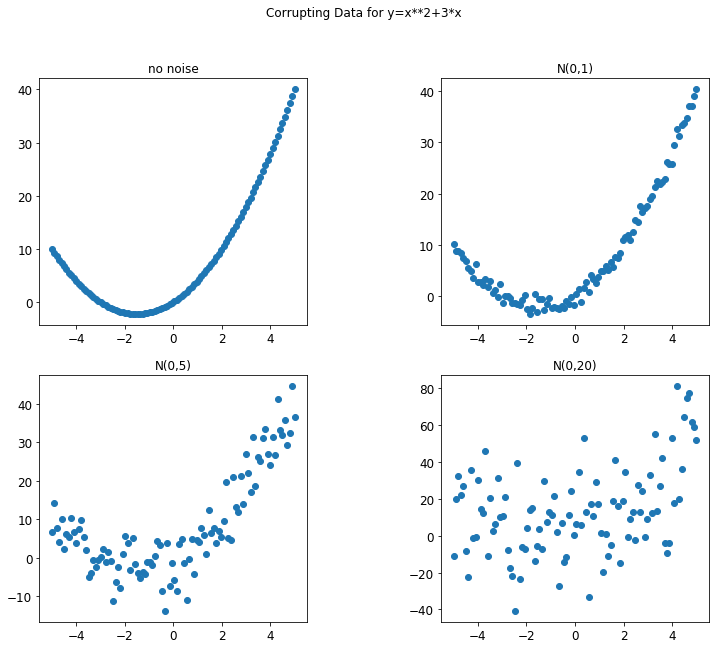

In [52]:
#Plot the two plots, one
fig, ax = plt.subplots(2,2,figsize=(12,10))
fig.suptitle("Corrupting Data for y=x**2+3*x")
fig.subplots_adjust(wspace=0.5)
ax[0,0].scatter(x,y)
ax[0,0].set_title("no noise")
ax[0,1].scatter(x,y_corrupt1)
ax[0,1].set_title("N(0,1)")
ax[1,0].scatter(x,y_corrupt2)
ax[1,0].set_title("N(0,5)")
ax[1,1].scatter(x,y_corrupt3)
ax[1,1].set_title("N(0,20)")

### Part 3
Build an autoencoder with one hidden layer and two neurons for the MNIST dataset. Plot the embedding layer and color it by the label of each image. Describe what you can learn about this dataset
from looking at the points embedded into the latent space of an autoencoder.

In [55]:
import numpy as np
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

#input mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#reshape as a single 784 length array, instead of 28x28
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#input dimension, here mnist is 28x28=784
input_dim = 784

#Dimension of hidden layer, only 2 neurons here
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(784,))
#"encoded" is the encoded representation of the input
encoded = Dense(encoding_dim)(input_img)
keras.layers.advanced_activations.LeakyReLU(alpha=0.3)
#"output_img" is the reconstruction of the input
output_img = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.2722
Epoch 2/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.2421
Epoch 3/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.2378
Epoch 4/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.2352
Epoch 5/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.2334
Epoch 6/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.2321
Epoch 7/10
60000/60000 [==============================] - 7s 118us/step - loss: 0.2310
Epoch 8/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.2300
Epoch 9/10
60000/60000 [==============================] - 8s 136us/step - loss: 0.2292
Epoch 10/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.2286


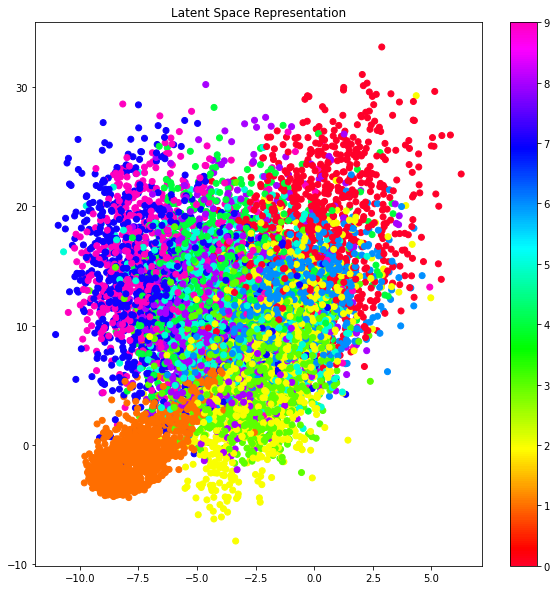

In [56]:
# Translate into the latent space
encoder = Model(input_img, encoded)
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='gist_rainbow')
plt.title("Latent Space Representation")
plt.colorbar()
plt.show()

**Comments:** <br>
Our latent space visualization of the data here is not as clearly clustered as other laten space representations available online for mnist data (e.g. https://thilospinner.com/towards-an-interpretable-latent-space/). However, I imagine this is because we only have one hidden layer and are forcing our network to learn the features of the digits in a single 784 to 2 dimensional encoding. This likely makes it very difficult to learn distinctive features of the digits, so the 2D latent space representations are not well defined clusters. We do see that there is some separateing between numbers in the largely overlapping groups. For example, the 0's (red) are clearly different from both the 1's (orange) and 7's (dark blue-purple). On the contrary, the 9's (pink) and 7's are very similar cluster. This is likely because 9's and 7's can often be written very similarly and so we are not able to learn their differences in a single 2 dimensional hidden layer.

## Problem 4
Variational Autoencoders (VAEs) and Generative Adversial Networks (GANs)

### Part 1
Describe the difference between a generative adversarial network (GAN) and a variational autoencoder
(VAE).
<br><br>
**Comments:**<br>
GANs contain two pieces, the generator and discriminator. The generator learns to construct fake images from random noise and the discriminator looks to classify the fake and real images that are inputed. Then the model is trained based on how the discriminator does at classifying the images. Overall, the goal is to produce very high quality fakes to trick the discriminator. In the variational autoencoder, like a traditional autoencoder, we want to learn a low dimensional encoding of the input images and then reconstruct the original input by decoding this lower dimensional representation. However, instead of representing the input as a single low-dimensional array, the variation autoencoder encodes the input as two different arrays, a mean and a standard deviation array. Then images are encoded as samples from normal distributions with these means and standard deviations. Similar to the GAN, this is an image of random Gaussian noise, which is then decoded to reconstruct the original image. Therefore, we can see these are both able to generate images from noise. However, the GAN has the additional discriminator that allows us to classify generated images versus real input data. The real input data is just streamed into the discriminator network with the fakes. Additionally, the GAN does not construct images from learned random distributions like the variational autoencoder (i.e. the learned mean and standard deviation arrays in the encoding layer), rather we can feed in simple noise.

### Part 2
Using the skeleton code in vae.py, fill in the TODOs to build a VAE. Plot 10 ten different inputs and
their reconstructions. Submit your filled-in version of vae.py along with the assignment.

In [28]:
# import MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("tmp/", one_hot=False)

import tensorflow as tf

# set params
batch_size = 32
input_dim = 784
num_iter = 2000

tf.reset_default_graph()

class VAE(object):
    def __init__(self, zdim=32, lr=.0001, batch_size=64):
        self.lr = lr
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.zdim = zdim
        self.build()

        # TODO: define a session here
        # self.sess = ...
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def encoder(self, x):
        with tf.variable_scope('encoder'):
            layer1 = tf.layers.dense(x, 256, name='layer1', activation=tf.nn.relu)
            layer2 = tf.layers.dense(layer1, 128, name='layer2', activation=tf.nn.relu)
            layer3 = tf.layers.dense(layer2, 64, name='layer3', activation=tf.nn.relu)

        mu = tf.layers.dense(layer3, self.zdim, name='mu')
        logsigma = tf.layers.dense(layer3, self.zdim, name='logsigma')

        return mu, logsigma

    def decoder(self, z):
        with tf.variable_scope('decoder'):
            layer1 = tf.layers.dense(z, 64, name='layer1', activation=tf.nn.relu)
            layer2 = tf.layers.dense(layer1, 128, name='layer2', activation=tf.nn.relu)
            layer3 = tf.layers.dense(layer2, 256, name='layer3', activation=tf.nn.relu)

        xhat = tf.layers.dense(layer3, self.input_dim, name='layer4', activation=tf.sigmoid)

        return xhat

    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, self.input_dim])

        # encoder
        mu, logsigma = self.encoder(self.x)

        # sample from random normal
        eps = tf.random_normal(shape=tf.shape(logsigma), mean=0, stddev=1)
        # reparameterization trick
        z = mu + tf.sqrt(tf.exp(logsigma)) * eps

        # decoder
        self.xhat = self.decoder(z)

        # TODO: define reconstruction loss here
        # recon_loss = ...
        recon_loss = tf.reduce_sum(tf.pow(self.x - self.xhat, 2))      

        # TODO: define kl loss here
        # kl_loss = ...
        kl_loss = - 0.5 * tf.reduce_sum(1 + logsigma - tf.pow(mu,2) - tf.pow(tf.exp(logsigma),2), axis=-1)

        
        self.loss_op = tf.reduce_mean(recon_loss) + tf.reduce_mean(kl_loss)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op)

    def train(self, x):
        self.sess.run(self.train_op, feed_dict={self.x: x})

    def get_reconstruction(self, x):
        xhat = self.sess.run(self.xhat, feed_dict={self.x: x})
        return xhat


vae = VAE()

for i in range(num_iter):
    if i % 500 == 0: print("Iter {} / {}".format(i, num_iter))
    vae.train(mnist.train.next_batch(batch_size)[0])

Extracting tmp/train-images-idx3-ubyte.gz
Extracting tmp/train-labels-idx1-ubyte.gz
Extracting tmp/t10k-images-idx3-ubyte.gz
Extracting tmp/t10k-labels-idx1-ubyte.gz
Iter 0 / 2000
Iter 500 / 2000
Iter 1000 / 2000
Iter 1500 / 2000


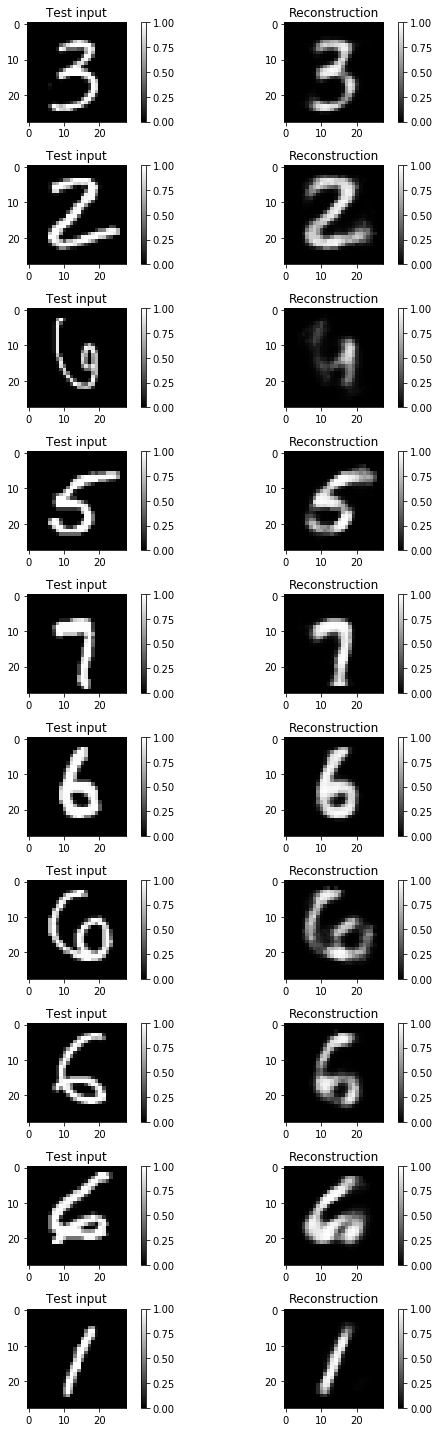

In [13]:
import matplotlib.pyplot as plt

x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.get_reconstruction(x_sample)

plt.figure(figsize=(8, 20))
for i in range(10):
    plt.subplot(10,2,2*i+1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(10,2,2*i+2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

### Part 3
What are some of the problems with trying to train GANs in practice? Name a few and discuss possible
ways of fixing/addressing them.
<br><br>
**Comments:**<br>
The main issue with training GANs is that the discriminator and generator are working against each other in minimizing their cost functions. One wants to continue to identify fake images, while the other looks to generate more and more realistic fake images to trick the other. This results in a minimax optimization problem that is non-convex and where convergence is not gauranteed (we can get stuck in saddle points). One potential way to address this is feature matching, where, instead of just focusing on the discriminator binary identifying the images as fake or real, the generator is learning the statistical features of the data (namely the expectation of the intermediate layer in the discriminator). Another possible issue could be mode collapse with the generator, where the generator continues to only generate points of a specific class (i.e. generating the same digit consistently). In the case of MNIST, this would lead to issues of generalized training across all digits (the gradient will continue to move in the same direction and not traing effectively). This can happen because we only train the discriminator on one sample at a time, therefore it is could be useful to train the discriminator on several images at a time (i.e. minibatch discrimination). It allows us to classify individual images in the context of other images. Both of these solutions come from the following paper: Improved Techniques for Training GANs from Tim Salimans, Ian Goodfellow, and others (https://arxiv.org/pdf/1606.03498.pdf).

### Part 4
Describe the differences between Kullback-Leibler divergence, Jensen-Shannon divergence, MMD, and
Wasserstein distance.
<br><br>
**Comments:**<br>
KL divergence measures the similarity between two distributions (say $P$ and $Q$), or more specifically how well one distribution approximates the other. An important aspect here is that KL divergence is asymmetric, so it is not a distance measurement. However, JS divergence is rather the sum of two KL divergences: both $P$ and $Q$ to their mixture $(P+Q)/2$. This means that JS divergence is indeed symmetric. We can compare the two measurements:
$$D_{KL}(P||Q) = \sum_{i} P(i)log\left(\frac{Q(i)}{P(i)}\right)$$
$$D_{JS}(P||Q) = \frac{1}{2} D_{KL}(P||\frac{P+Q}{2}) + \frac{1}{2} D_{KL}(Q||\frac{P+Q}{2})$$
Here we see that the KL divergence between P and Q and between Q and P are asymmetric as the, the logarithm would switch and the first term in the sum will be the probability density of either P or Q depending on which direction you are calculating the divergence. However, because of the commutative property of addition, the JS divergence remains symmetric.
<br>
The maximum mean discrepancy (MMD) is exactly what it sounds: given two samples X and Y from i.i.d. distributions P and Q respectively, the MMD is the supremum of the differences in expectations of each sample. The Wasserstein distance, or earth mover's distance, is intuitively the cost of moving one pile of dirt from one pile to another. This is essentially equivalent to the quantity of dirt times the distance that the dirt needs to be moved. So here, we must integrate across the probability density functions of the distributions to understand the amount of "dirt in each pile."

### Part 5
Why do we often choose the input to a GAN ($z$) to be samples from a Gaussian? Can you think of
any potential problems with this?
<br><br>
**Comments:**<br>
We often choose the input $z$ to be Gaussian, because this is the traditional continuous distribution used to model noise (i.e. $\epsilon$ in a linear model when fitting a linear model). This is just the best choice for a least known random noise, however we can always adjust these assumptions if we gain more information. Therefore, to generate fake images from random noise, the Gaussian tends to be the best choice. Recall, we also use the Gaussian when adding noise to the denoising autoencoder and that in the variational autoencoder the data is encoded into two arrays, being the means and standard deviations for Gaussian distributions that will be sampled. In general, a problem is that we are over-simplifying in making an assumption about requiring Gaussian noise as the input (however, as I said, we can always continue to adjust our assumptions based on additional information). If the Gaussian is not a good fit for the latent space distribution, then our model will perform poorly and we will need to edit our assumptions.

### Part 6
In class we talked about using GANs for the problem of mapping from one domain to another (e.g. faces
with black hair to faces with blond hair). A simple model for this would learn two generators: one that
takes the first domain as input and produces output in the second domain as judged by a discriminator,
and vice versa for the other domain. What are some of the reasons the DiscoGAN/CycleGAN perform
better at this task than the simpler model?
<br><br>
**Comments:**<br>
The DiscoGAN does a good job at this because it then maps the the second domain output back to the first domain and is then judged on this reconstruction loss. We want to minimize this loss of sending the image back to the first domain and comparing to the original image in the first domain. Additionally, the DiscoGAN trains the same weights in different ways, in one direction it is converting the original image from a first domain to second domain and in another it is reconstructing an image from the first domain back to the original second domain. These are two different tasks, but uses the same A domain to B domain network. We have the same double use of a B domain to A domain network as well. The CycleGAN is essentially the same structure, but adds the additional constraint that if one image is already in the second domain, that mapping it from domain A to domain B (again it is already in domain B) will just produce the same image in domain B. Specifically $G_{ab}(X_b) = X_b$, where $G_{ab}$ is mapping from domain A to domain B and $X_b$ means the data is already in domain B.